In [1]:
import specsuite as ss
import matplotlib.pyplot as plt
import numpy as np

## _What is GMOS-N?_
Attached to the 8.0-meter telescope at Gemini North Telescope at Mauna Kea, Hawaii is the Gemini Multi-Object Spectrograph (GMOS-N). This is a long-slit / multi-slit multi-object spectograph capable of observing from blue-visible into near-infrared wavelengths of light with a resolving power ranging from 210-8800 (depending on instrument configuration). Since this is a ground-based telescope, it is subject to the time-dependent contamination of Earth's atmosphere.

In the following reduction, we process five exposures of TOI-3884 using GMOS-N. We will not perform a wavelength calibration (since this relies on interactive code), and we will not perform a flux calibration (in an attempt to keep as little data as possible on the GitHub repository).

## _Reduction_
### _Loading Data_
Although you are able to load data using the same functions shown previously in the documentation, there are some extra complications that GMOS-N presents during the loading process. Firstly, the FITS files produced by GMOS-N have twelve separate headers, each containing a portion of the complete readout. Secondly, the detector is comprised of three chips that are separated by a gap (~61 pixels in length). We need to represent these gaps using NaN values to prevent logical errors during the wavelength calibration, but we also need to mask those out before further analysis (since many of the processing functions were not made to handle NaN columns). Let's start by just loading in the relevant data...

In [14]:
CAL_PATH = "../data/GMOS/calibrations"
DATA_PATH = "../data/GMOS/target"
DATA_REGION = (1750, 1950)

# Loads standard calibration images
full_bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
)
full_flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat", 
    instrument="GMOS",
    crop_bds = DATA_REGION,
)
full_arc = ss.average_matching_files(
    path = "../data/GMOS/calibrations",
    tag = "CuAr",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
)

# Collects individual science exposures
full_science = ss.collect_images_array(
    path = DATA_PATH,
    tag = "toi3884",
    instrument = "GMOS",
    crop_bds = DATA_REGION,
)

# Loads the RN image for a single GMOS-N exposure
_, full_RN = ss.loading._GMOS_loader(
    path = "../data/GMOS/target",
    file = "toi3884.0017.fits",
    return_RN = True,
)
full_RN = full_RN[DATA_REGION[0]:DATA_REGION[1]]

Let's also go ahead and plot these exposures...

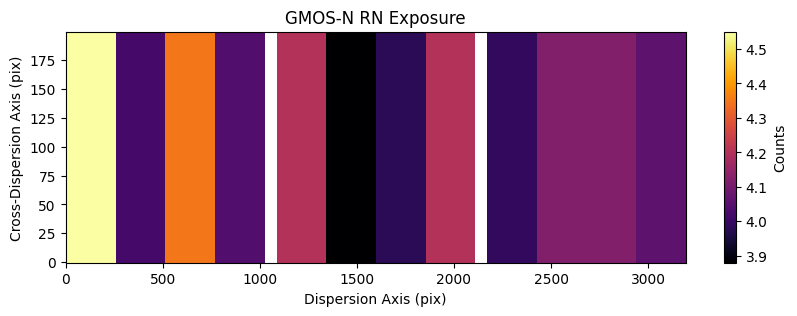

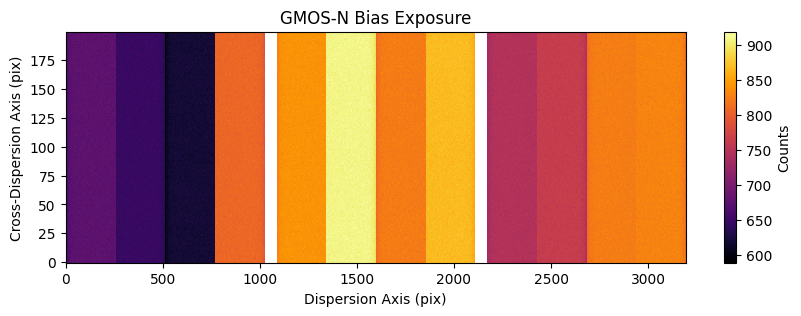

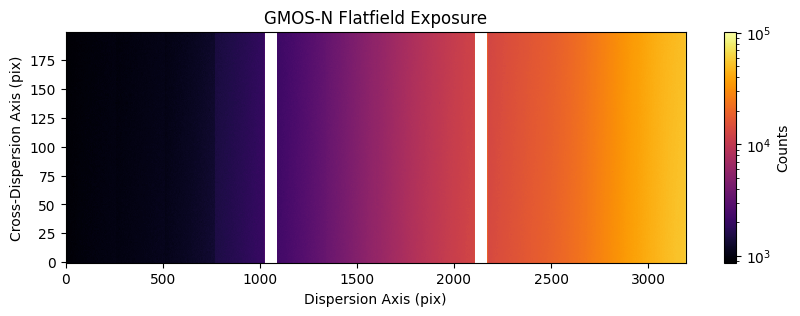

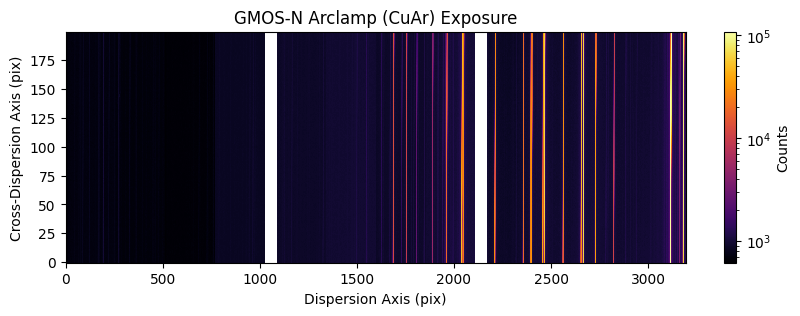

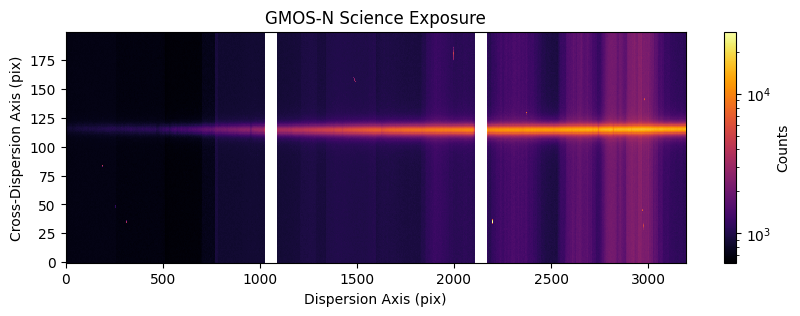

In [16]:
# Plots all the loaded exposures
ss.plot_image(
    full_RN,
    title="GMOS-N RN Exposure",
)
ss.plot_image(
    full_bias,
    title = "GMOS-N Bias Exposure",
)
ss.plot_image(
    full_flat,
    norm = 'log',
    title = "GMOS-N Flatfield Exposure",
)
ss.plot_image(
    full_arc,
    norm = 'log',
    title = "GMOS-N Arclamp (CuAr) Exposure",
)
ss.plot_image(
    full_science[0],
    norm = 'log',
    title = "GMOS-N Science Exposure",
)

We can see that these "chip gaps" appear as entirely white columns in our data. For data that looks like this, it is often simplest to split up each chip and process them individually. For simplicity, we will only process data from the rightmost chip.

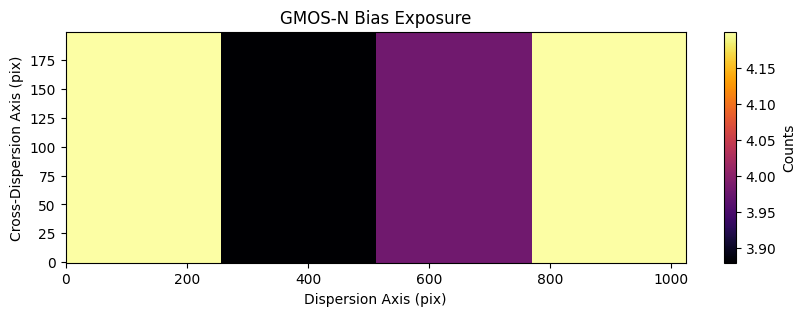

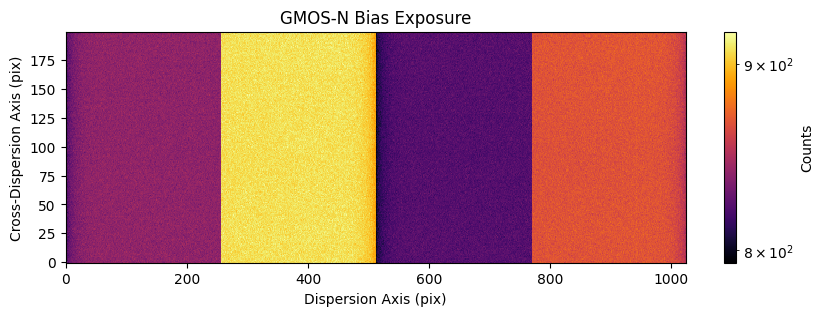

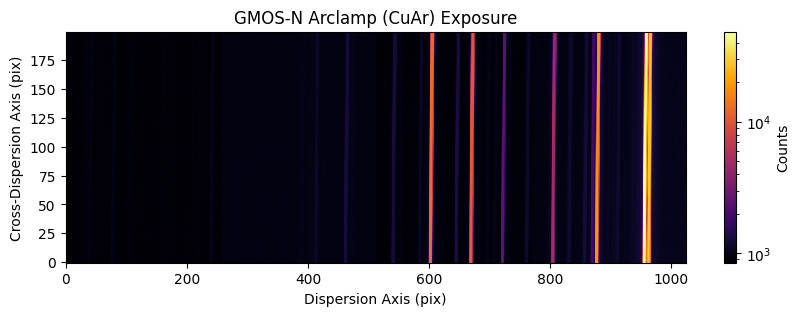

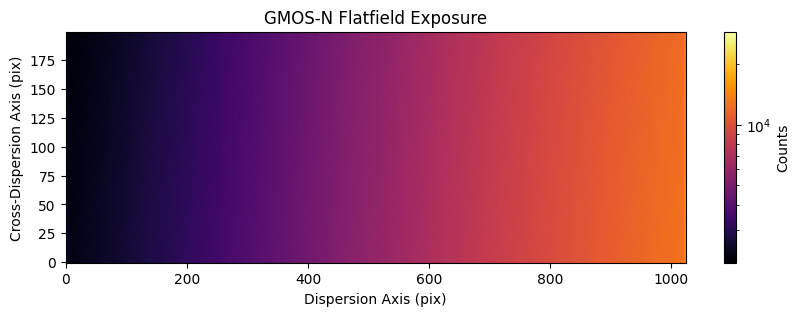

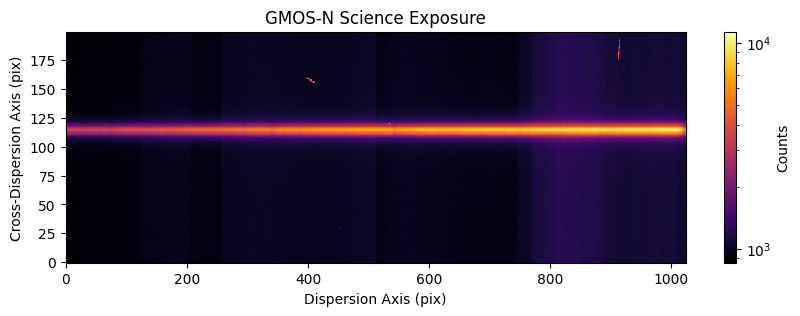

In [17]:
chip_idx = 1

# Only keeps data from the rightmost chip
RN = ss.split_chips(full_RN)[0][chip_idx]
bias = ss.split_chips(full_bias)[0][chip_idx]
raw_arc = ss.split_chips(full_arc)[0][chip_idx]
raw_flat = ss.split_chips(full_flat)[0][chip_idx]
raw_science = ss.split_chips(full_science)[:, chip_idx]

ss.plot_image(RN, title="GMOS-N Bias Exposure")
ss.plot_image(bias, norm='log', title="GMOS-N Bias Exposure")
ss.plot_image(raw_arc, norm='log', title="GMOS-N Arclamp (CuAr) Exposure")
ss.plot_image(raw_flat, norm='log', title="GMOS-N Flatfield Exposure")
ss.plot_image(raw_science[0], norm='log', title="GMOS-N Science Exposure")

### _Standard Calibrations_
With loading / splitting chips out of the way, we can perform some basic calibrations on our data! For this data, that just involves subtracting off the median bias exposure and performing a flatfield correction...

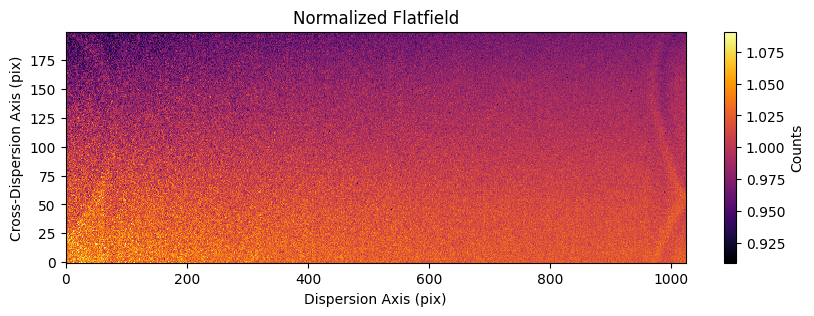

In [4]:
# Subtracts off bias from all exposures
arc = raw_arc - bias
flat = raw_flat - bias
science = raw_science - bias

# Performs a flatfield correction for all science exposures
science = ss.flatfield_correction(
    image = science,
    flat = flat,
    debug = True,
)

Unless there is a notable oddity in your flatfield or bias (see the KOSMOS example), there should not be anything to double-check during this step! If you run into odd results further along your pipeline, checking that these corrections work as you expect them to is a good first step.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        For many telescopes, you may also take a series of "dark" exposures to see how much light your instrument gives off when not illuminated. While this is typically good practice, dark current contamination is too low to significantly impact our reduction. The technical documentation estimates that dark current only produces a single DN of contamination over roughly an hour-long exposure.
    </p>
</div>

### _Background Extraction_
Next, we will generate a "warp model" to use in a background extraction. Since GMOS-N is a fairly sensitive instrument, the threshold needed to identify line emissions in our arclamp exposure is much lower. A value of 6 works pretty well!

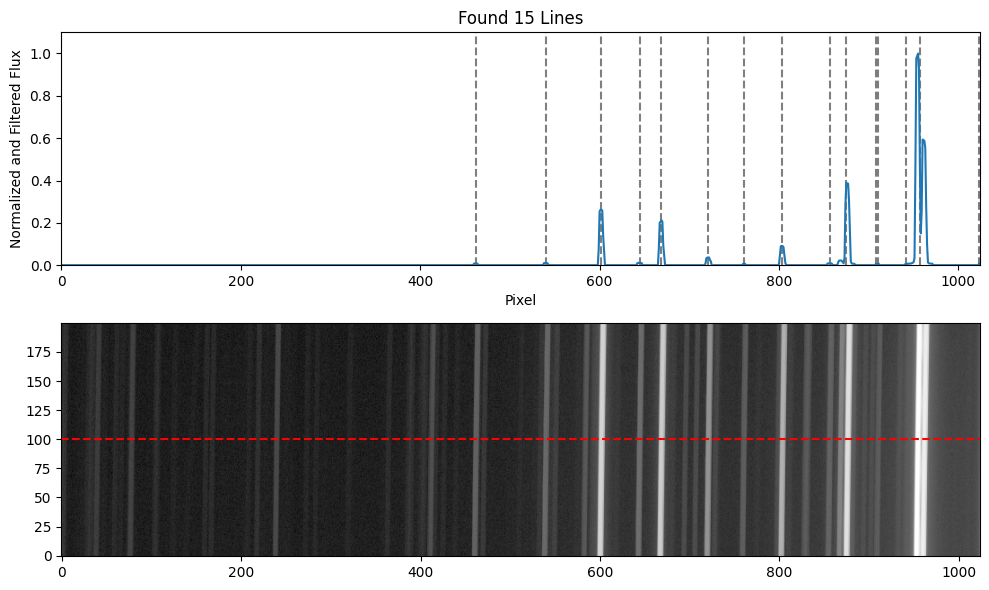

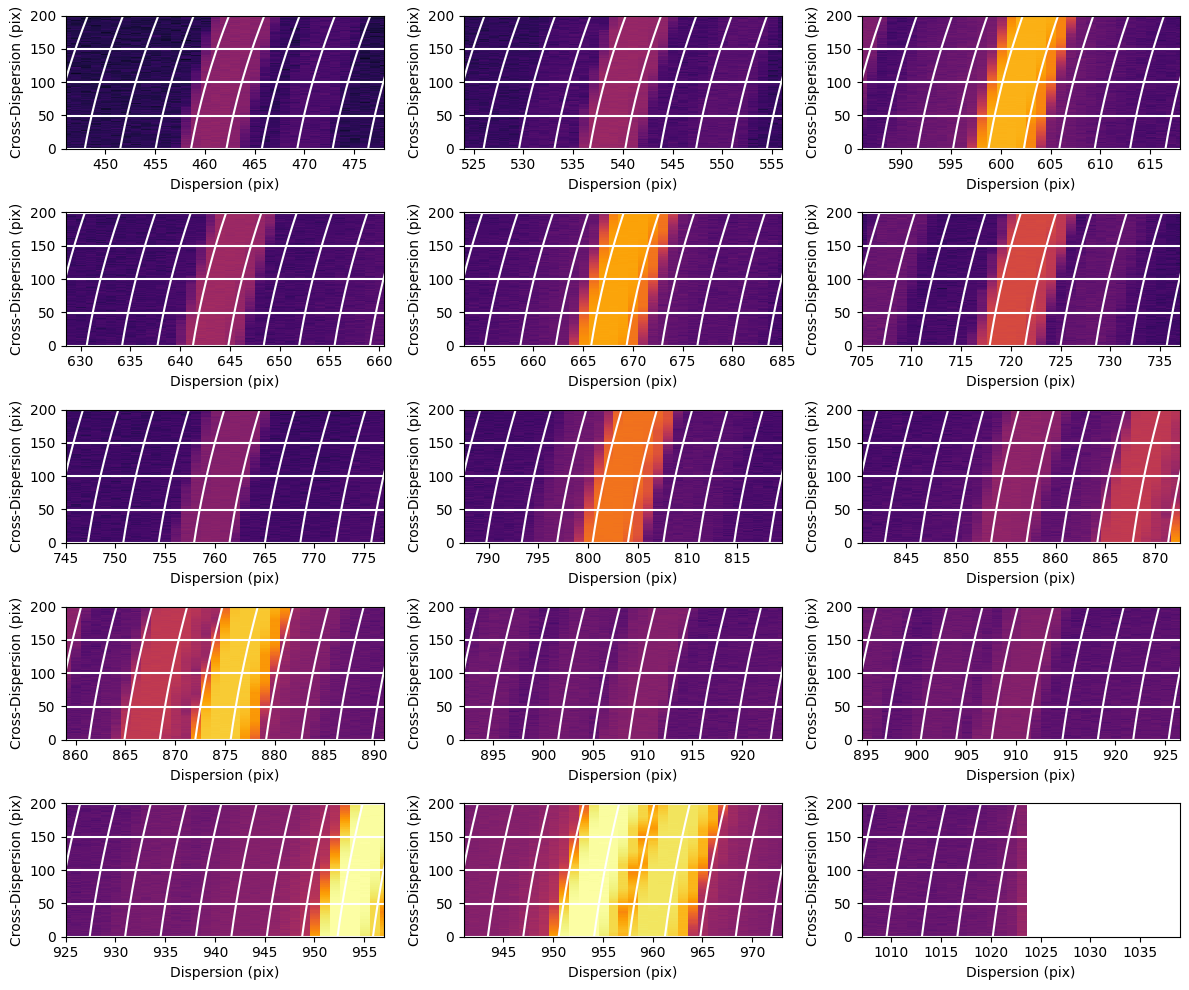

In [5]:
locs, _ = ss.find_cal_lines(
    image = arc,
    std_variation = 6,
    debug = True,
)

warp_model = ss.generate_warp_model(
    image = arc,
    guess = locs,
    debug = True,
)

We can see that the white grid seems to do a good job tracing out the shape of line emissions in our arclamp exposure, so our warp model is reasonably accurate! Let's go ahead and extract the background from our science exposures...

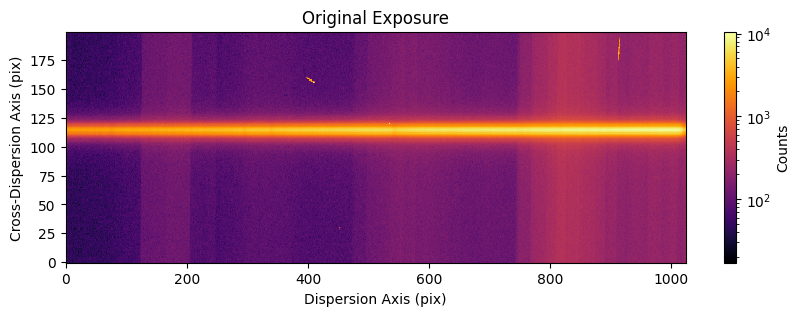

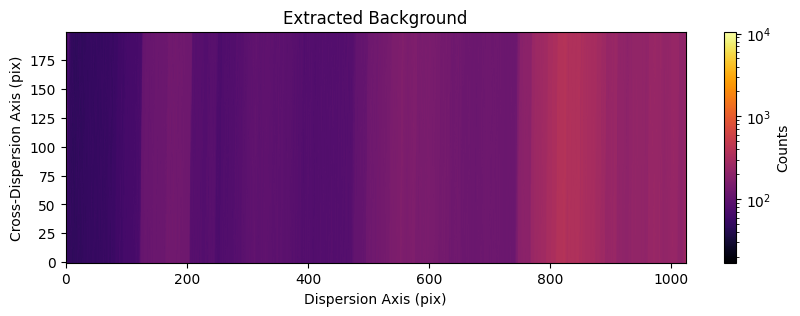

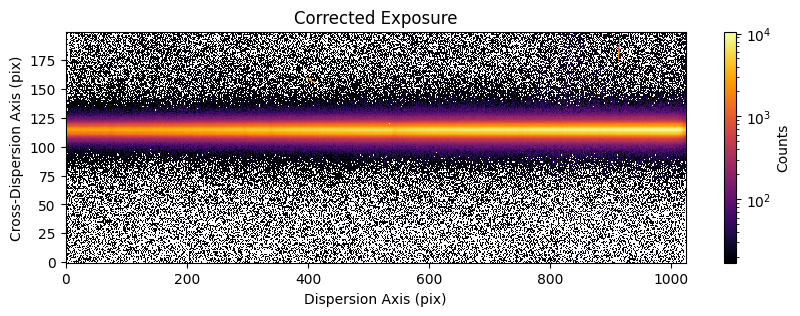

In [6]:
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (75, 150),
    debug = True,
)

Since the region of the image that our target does not illuminate looks like random static, we can be reasonably certain that our background extraction is accurate!

### Flux Extraction
There are currently two method available for extracting flux from your science exposures. These correspond with the standard "boxcar" and "horne (optimal)" extractions used in many other reduction pipelines. Since the boxcar extraction is less likely to hit a snag and fail, let's start there...

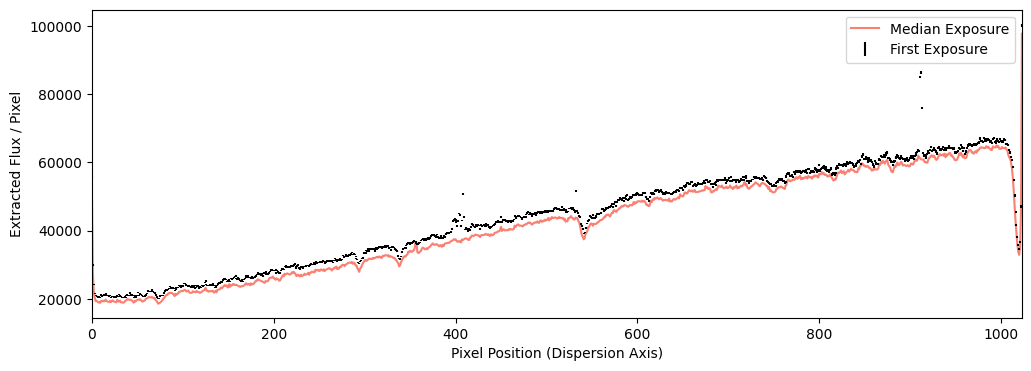

In [7]:
boxcar_flux, boxcar_error = ss.boxcar_extraction(
    images = (science - backgrounds),
    backgrounds = backgrounds,
    RN = RN,
    debug = True,
)

You may notice that the "first exposure" (black) is consistently higher than the "median exposure." This is an odd feature in this particular dataset, but should not significantly impact the following visualizations. If we perform the profile-weighted exposure, we will see the same trend...

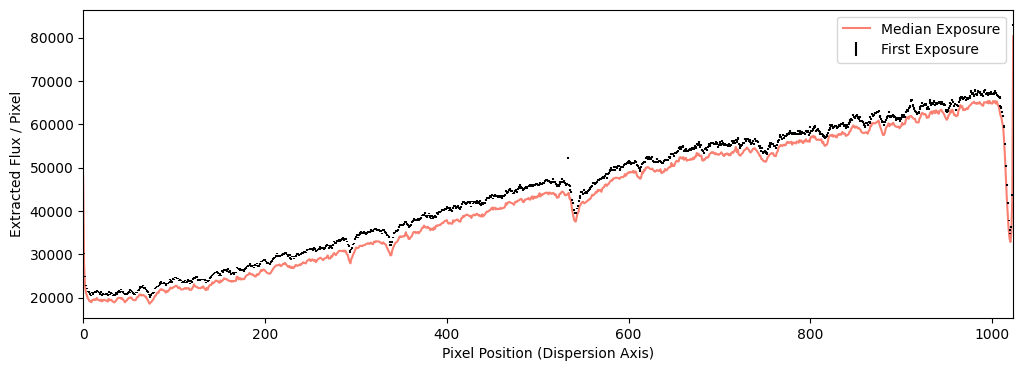

In [8]:
horne_flux, horne_error = ss.horne_extraction(
    images = science - backgrounds,
    backgrounds = backgrounds,
    RN = RN,
    debug = True,
)

Compared against the boxcar extraction, the data appears to be slightly less noisy! To help visualize this difference, let's take a look at the extracted SNR for each of these extractions...

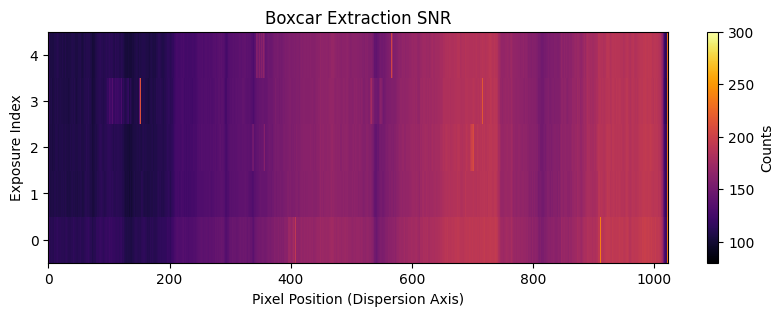

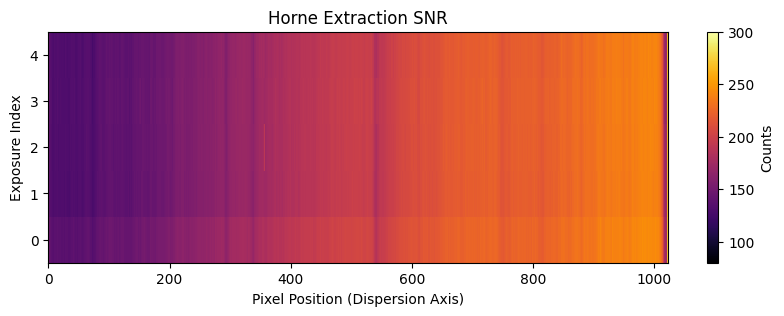

In [9]:
# Plots Boxcar Extraction
ss.plot_image(
    boxcar_flux/boxcar_error,
    title = "Boxcar Extraction SNR",
    xlabel = "Pixel Position (Dispersion Axis)",
    ylabel = "Exposure Index",
    vmin = 80,
    vmax = 300,
)

# Plots Horne Extraction
ss.plot_image(
    horne_flux/horne_error,
    title = "Horne Extraction SNR",
    xlabel="Pixel Position (Dispersion Axis)",
    ylabel="Exposure Index",
    vmin = 80,
    vmax = 300,
)

While the profile-weighted extraction produces a higher SNR across all wavelengths, the benefit is most noticeable for blue (left) wavelengths! We will explore this trend more in the next section.

### _Processing All Three Chips_
As of now, the easiest way to process multiple GMOS-N chips is to treat them each as individual detectors, then combine each reduced SED at the end. Below, we will reduce data for all three chips in a large loop...

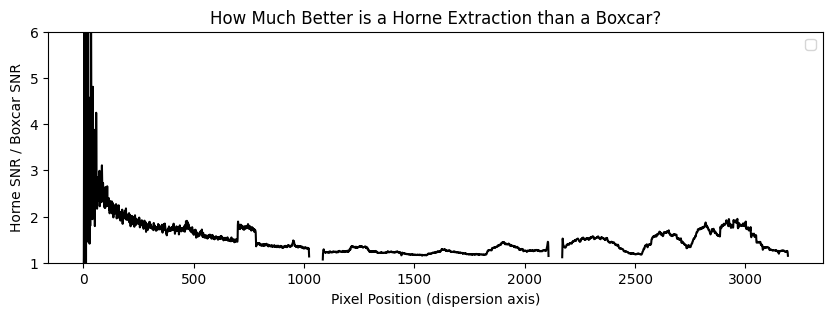

In [ ]:
for chip_idx in range(3):

    # Pulls the data for a single chip
    RN = ss.split_chips(full_RN)[0][chip_idx]
    arc = ss.split_chips(full_arc)[0][chip_idx]
    bias = ss.split_chips(full_bias)[0][chip_idx]
    flat = ss.split_chips(full_flat)[0][chip_idx]
    science = ss.split_chips(full_science)[:, chip_idx]

    # Subtracts off bias from all exposures
    arc -= bias
    flat -= bias
    science -= bias

    # Performs a flatfield correction for all science exposures
    science = ss.flatfield_correction(
        image = science,
        flat = flat,
    )

    # Constructs a warp model using the arclamp exposure
    locs, _ = ss.find_cal_lines(
        image = arc,
        std_variation = 6,
    )
    warp_model = ss.generate_warp_model(
        image = arc,
        guess = locs,
    )

    # Extracts the background emissions
    backgrounds = ss.extract_background(
        images = science,
        warp_model = warp_model,
        mask_region = (75, 150),
    )

    # Performs and Horne extraction to all images
    flux, error = ss.boxcar_extraction(
        images = science - backgrounds,
        backgrounds = backgrounds,
        RN = RN,
    )
    boxcar_flux = np.median(flux, axis=0)
    boxcar_error = np.median(error, axis=0)

    # Performs and Horne extraction to all images
    flux, error = ss.horne_extraction(
        images = science - backgrounds,
        backgrounds = backgrounds,
        RN = RN,
    )
    horne_flux = np.median(flux, axis=0)
    horne_error = np.median(error, axis=0)

    # Determines the pixel locations for each chip
    xs = np.array(range(len(horne_flux)))
    if chip_idx == 1:
        xs += 61 + len(xs)
    if chip_idx ==2:
        xs += 2*61 + 2*len(xs)

    plt.plot(
        xs,
        np.abs((horne_flux/horne_error)/(boxcar_flux/boxcar_error)),
        color='black',
    )

plt.ylim(1, 6)
plt.title("How Much Better is a Horne Extraction than a Boxcar?")
plt.xlabel("Pixel Position (dispersion axis)")
plt.ylabel("Horne SNR / Boxcar SNR")
plt.show()

We can see that the SNR the profile-weighted extraction produces a SNR that is anywhere from ~1.5x greater (red to NIR) to ~5x greater (blue visible) than that of the boxcar extraction. In general, the boxcar extraction is most useful for getting a quick look at your data, and the Horne extraction should be used for your final, analysis-ready reduction.

## _What Comes Next?_

Once you have an extracted SED, your next steps will depend greatly on the purpose of your observation. If you care about the flux-calibrated SED of your target, then you will need to use some of the functions outlined in ```Additional Tools > Flux Calibration```. If you are only interested in the relative changes in brightness for your target, then you may need to repeat the above reduction for another in-slit comparison star.

Regardless, you will likely need to perform a wavelength calibration to convert pixel position into units of wavelength. Consider using our interactive widget for this!

In [11]:
# Fill with your own data
pixel_list = [...]
wavelength_list = [...]

# Initialize widget
wavecal_widget = ss.WavecalWidget(
    upper_lines = pixel_list,
    lower_lines = wavelength_list,
)

#wavecal_widget.activate_widget()   <--- Uncomment this to use widget

![Initial widget layout](../assets/widget_initial_configuration.png)